# Google Colab TPU 사용

In [1]:
# TPU 초기화
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

# TPU strategy(분산처리 전략) 세팅
strategy = tf.distribute.TPUStrategy(resolver)

# def creae_model() 안해도 됨
# 모든 실습코드 상단에 아래 코드 입력
## with strategy.scope(): 

# 사전학습 모델1: VGG 모델

## VGG모델: 데이터 전처리

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
# from tf.kerasapplications.vgg16 import preprocess_input
from tensorflow.keras.applications.imagenet_utils import preprocess_input

with strategy.scope(): 
  #1: RGB
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  x_train = x_train.astype('float32')

  #2: default mode 'caffe' style, BGR
  X = x_train.copy()
  Y1 = preprocess_input(X)
  del X  # 메모리 삭제

170498071/170498071 [==============================] - 2s 0us/step


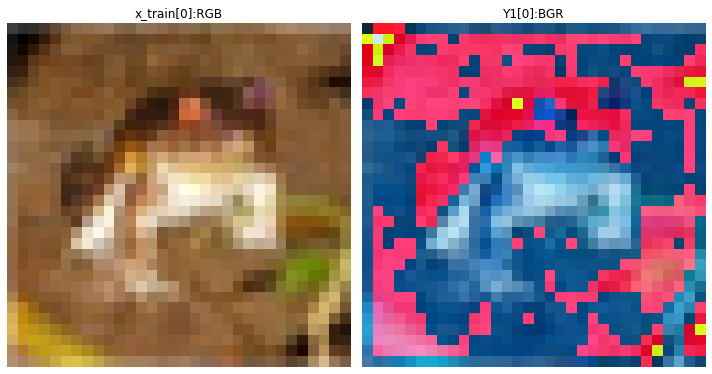

In [7]:
with strategy.scope(): 
  #5: display image: x_train[0,:,:,:], Y1[0,:,:,:]
  fig, ax = plt.subplots(1, 2, figsize=(10, 6))
  ##ax[0].imshow(x_train[0,:,:,:]/255.0)
  ax[0].imshow(x_train[0,:,:,:].astype(np.uint8))
  ax[0].set_title("x_train[0]:RGB")
  ax[0].axis("off")

  mean = np.array([103.939, 116.779, 123.68], dtype=np.float32)  # ImageNet
  Y1 += mean
  ##ax[0].imshow(Y1[0,:,:,:]/255.0)
  ax[1].imshow(Y1[0,:,:,:].astype(np.uint8))
  ax[1].set_title("Y1[0]:BGR")
  ax[1].axis("off")

  fig.tight_layout()
  plt.show()

## VGG모델: 사전학습 가중치 이용한 분류(Classification)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

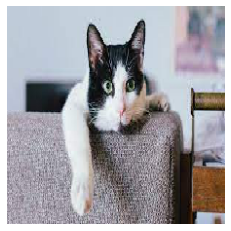

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

#2:
model = VGG16(weights = 'imagenet', include_top = True)
model.summary()

#3: predict an image
img_path = '/content/cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
output = model.predict(x)

#3-1: (class_name, class_description, score)
print('Predicted:', decode_predictions(output, top=5)[0]) # decode_predictions : 예측 결과 중 최상위 5개 항목 반환

#4: display image and labels
plt.imshow(img)
plt.axis('off')
plt.show()

## VGG모델: 모델 구조만 사용해서, CIFAR-10 학습하기

- Imagenet 으로 사전학습된 가중치 사용하지 않고, 모델 구조만 가져와서 from the scratch로 처음부터 학습

In [15]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import preprocess_input, VGG16
import numpy as np
import matplotlib.pyplot as plt
# from tf.kerasapplications.vgg16 import preprocess_input

with strategy.scope(): 
  #2
  (x_train, y_train), (x_trest, y_test) = cifar10.load_data()  # 데이터 로드
  x_train = x_train.astype('float32')  # 훈련 데이터 각 값을 실수 형태로 변환
  x_test = x_test.astype('float32')

  # one-hot encoding
  y_train = tf.keras.utils.to_categorical(y_train)  # 레이블 값 원핫 인코딩 벡터로 변환
  y_test = tf.keras.utils.to_categorical(y_test)

  # 3: preprocessing, 'caffe', x_train, x_test: BGR
  x_train = preprocess_input(x_train)  # 훈련 데이터 전처리: 채널 순서를 RGB에서 BGR로 변경
  x_test = preprocess_input(x_test)

  #4: VGG16에서, 사전학습된 가중치 사용하지 않음. 모델 전체 틀만 가져옴
  ## include_top=True : 완전연결 층 붙인 상태로 모델 로드
  ## 분류할 클래스 갯수 = 10개
  ## Input의 shape = (32, 32, 3) : 32*32 이미지, RGB 3차원
  model = VGG16(weights=None, include_top=True, classes=10, input_shape=(32,32,3))
  model.summary()

  #5: train and evaluate the model
  opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  ret = model.fit(x_train, y_train, epochs=100, batch_size=400,
                  validation_split=0.2, verbose=1)
  

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

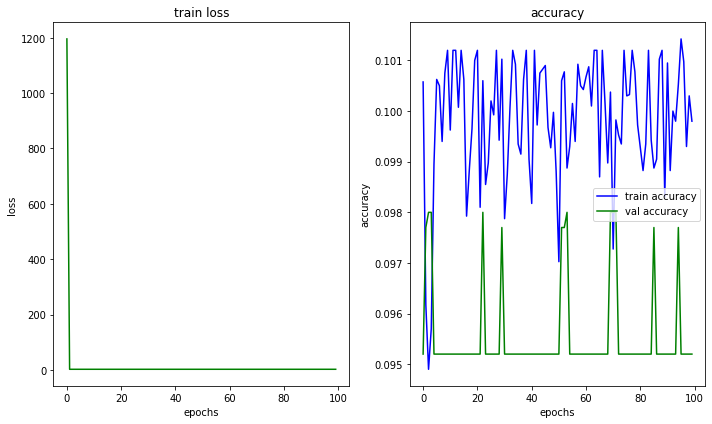

In [16]:
with strategy.scope(): 
  #6: plot accuracy and loss
  fig, ax = plt.subplots(1, 2, figsize=(10, 6))
  ax[0].plot(ret.history['loss'], 'g-')
  ax[0].set_title("train loss")
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('loss')

  ax[1].plot(ret.history['accuracy'], 'b-', label = 'train accuracy')
  ax[1].plot(ret.history['val_accuracy'], 'g-', label = 'val accuracy')
  ax[1].set_title("accuracy")
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')

  plt.legend()
  fig.tight_layout()
  plt.show()